<a href="https://colab.research.google.com/github/sechmo/IA-minirobots-2023-II/blob/master/6.%20Machine%20Learning/2.%20Square%20Root/sqrt_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating square roots with Neural Networks

## Initial Setup

We load pytorch to use its neural networks and optimizer and matplotlib to graph our results

In [40]:
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.utils.data as da
import matplotlib.pyplot as plt

In [14]:
# Checking the pytorch version being used
torch.__version__

'2.1.0+cu118'

In [15]:
# Choosing the best available training hardware
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Dataset generation

As pytorch also offers a comprehensive linear algebra library (similar and somewhat compatible with numpy), we are going to use it to generate the dataset, with the extra benefit that we can preload the data to a device like a GPU and speed up training considerably. We are going to consider integer values up to 1000

In [16]:
# A random vector for our input

upper_limit = 50

training_input = torch.randint(upper_limit+1,(1_000_000,1), dtype=torch.float32, device=device)
training_output = torch.sqrt(training_input)

test_input = torch.randint(upper_limit+1,(200_000,1), dtype=torch.float32, device=device)
test_output = torch.sqrt(test_input)

With the generated values we can create a create the corresponding pytorch compatible dataset and data loader

In [17]:
training_ds = da.TensorDataset(training_input,training_output)
test_ds = da.TensorDataset(test_input, test_output)

In [18]:
batch_size=2024
training_dl = da.DataLoader(training_ds, batch_size=batch_size, shuffle=True)
test_dl = da.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

## Training and testing

We define some common generic functions to train our model.

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error:  Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

## The neural network

Here we define our layers of neurons, we are going to use tanh activation functions, we feel the similarity with the sqrt function with help with the learning. Neurons will be usual linear layers.

In [20]:
class SqrtNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

model = SqrtNN().to(device)
print(model)

SqrtNN(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)


## Metaparameters

As plenty of data can be used, we will opt for a not so small learning rate, and relativele many epochs.

In [21]:
learning_rate = 1e-3
epochs = 20

Backpropagation pptimization will be done with Stochastic gradient descent.

In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

Loss will be measured with absolute error

In [23]:
loss_fn = nn.L1Loss()

## Training

In [24]:
accuracies = []
losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_dl, model, loss_fn, optimizer)
    acc, loss = test(test_dl, model, loss_fn)
    accuracies.append(acc)
    losses.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 4.971354  [ 2024/1000000]
loss: 0.912748  [204424/1000000]
loss: 0.689743  [406824/1000000]
loss: 0.622721  [609224/1000000]
loss: 0.735611  [811624/1000000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.503360 

Epoch 2
-------------------------------
loss: 0.514840  [ 2024/1000000]
loss: 0.510010  [204424/1000000]


Exception ignored in: <function _xla_gc_callback at 0x7dadc1ecd870>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


loss: 0.487546  [406824/1000000]
loss: 0.483104  [609224/1000000]
loss: 0.448917  [811624/1000000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.738758 

Epoch 3
-------------------------------
loss: 0.726906  [ 2024/1000000]
loss: 0.718439  [204424/1000000]
loss: 0.642680  [406824/1000000]
loss: 0.539657  [609224/1000000]
loss: 0.607521  [811624/1000000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.344318 

Epoch 4
-------------------------------
loss: 0.338736  [ 2024/1000000]
loss: 0.389750  [204424/1000000]
loss: 0.390629  [406824/1000000]
loss: 0.391278  [609224/1000000]
loss: 0.362353  [811624/1000000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.565936 

Epoch 5
-------------------------------
loss: 0.554294  [ 2024/1000000]
loss: 0.497438  [204424/1000000]
loss: 0.603664  [406824/1000000]
loss: 0.525373  [609224/1000000]
loss: 0.529882  [811624/1000000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.408950 

Epoch 6
-------------------------------
loss: 0.409478  [ 2024/1000000]
loss: 0.35205

## Results

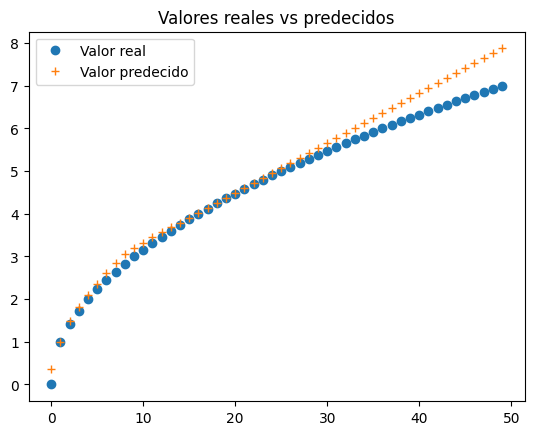

In [56]:
with torch.no_grad():
  simple_test = torch.reshape(torch.arange(upper_limit,dtype=torch.float32,device=device), (upper_limit,1))
  model_result = model(simple_test)
  actual_result = torch.sqrt(simple_test)
  simple_test = simple_test.cpu().numpy()
  model_result = model_result.cpu().numpy()
  actual_result = actual_result.cpu().numpy()

  plt.plot(simple_test,actual_result,'o',label="Valor real")
  plt.plot(simple_test, model_result, '+', label="Valor predecido")
  plt.legend()
  plt.title("Valores reales vs predecidos")

The model got pretty close to mos numbers, particularly those on the range between 15 and 25, however deviation is noticeable after 30, the model struggles with bigger numbers.